# Math 124 - Programming for Mathematical Applications
UC Berkeley, Spring 2020

## Project 3 - Triangular mesh generator

Due Wednesday, April 8

First we include some libraries and define utility functions from the lecture notes:

In [1]:
using PyPlot, LinearAlgebra, PyCall

function tplot(p, t)
    # Plot triangular mesh with nodes `p` and triangles `t`
    tris = convert(Array{Int64}, hcat(t...)')
    tripcolor(first.(p), last.(p), tris .- 1, 0*tris[:,1],
              cmap="Set3", edgecolors="k", linewidth=1)
    axis("equal")
    return
end

function delaunay(p)
    # Delaunay triangulation `t` of array of nodes `p`
    tri = pyimport("matplotlib.tri")
    t = tri[:Triangulation](first.(p), last.(p))
    t = Int64.(t[:triangles] .+ 1)
    t = [ t[i,:] for i = 1:size(t,1) ]
end

delaunay (generic function with 1 method)

### Description

In this project you will write an unstructured triangular mesh generator based on the Delaunay refinement algorithm. The steps will be described in detail, and for testing we will use the following simple polygon:

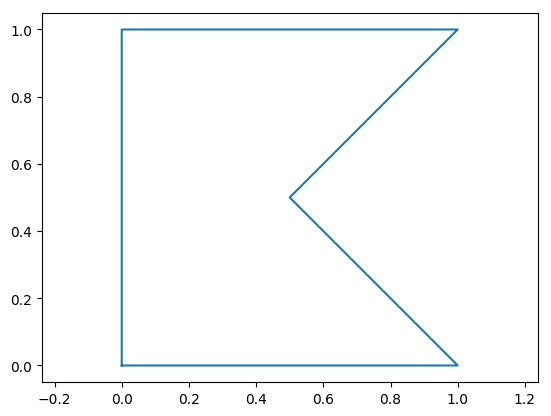

In [2]:
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
plot(first.(pv), last.(pv))
axis("equal");

### Problem 1 - Point in polygon

Write a function `inpolygon(p, pv)` which determines if a point `p` is inside the closed polygon `pv`. For example, in the test polygon above, the point $(0.6,0.3)$ is inside but $(0.8,0.3)$ is outside. For the algorithm, use the "Crossing number method" as described here: <http://geomalgorithms.com/a03-_inclusion.html>.

In [3]:
function inpolygon(p, pv)
    
    cn = 0
    for i in 1:(length(pv)-1)
        y_difference = pv[i+1][2]-pv[i][2]
        x_difference = pv[i+1][1]-pv[i][1]
        gradient = (y_difference)/(x_difference)
        y_crossing = pv[i][2] - gradient*(pv[i][1])
        if gradient != 0
            if (gradient == Inf) || (gradient == -Inf)
                if p[1] < pv[i][1]
                    if y_difference < 0 && (pv[i][2]>p[2]>=pv[i+1][2])
                        cn += 1
                    elseif y_difference > 0 && (pv[i][2]<=p[2]<pv[i+1][2])
                        cn += 1
                    end
                end
            elseif (p[1] <= (p[2] - y_crossing)/gradient) 
                if y_difference < 0 && (pv[i][2]>p[2]>=pv[i+1][2])
                    cn += 1
                elseif y_difference > 0 && (pv[i][2]<=p[2]<pv[i+1][2])
                    cn += 1
                end
            end
        end
    end
    
    return (cn % 2 != 0)
end

inpolygon (generic function with 1 method)

### Problem 2 - Triangle properties

Next we need functions for computing some basic quantities from triangles. Here, a triangle `tri` is represented as an array of 3 points, e.g.

In [4]:
tri = [[1,0.5], [2,1], [0,3]]

3-element Array{Array{Float64,1},1}:
 [1.0, 0.5]
 [2.0, 1.0]
 [0.0, 3.0]

### Problem 2(a) - Triangle area

Write a function `tri_area(tri)` which returns the area of `tri`.

In [5]:
function tri_area(tri)
    
    # finding half of perimeter
    a = sqrt((tri[1][1]-tri[2][1])^2+(tri[1][2]-tri[2][2])^2)
    b = sqrt((tri[2][1]-tri[3][1])^2+(tri[2][2]-tri[3][2])^2)
    c = sqrt((tri[3][1]-tri[1][1])^2+(tri[3][2]-tri[1][2])^2)
    p = a + b + c
    half_p = p/2
    
    # finding area using herons formula
    area = sqrt(abs(half_p*(half_p-a)*(half_p-b)*(half_p-c)))
    
    return area
end

tri_area(tri)

1.5

### Problem 2(b) - Triangle centroid

Write a function `tri_centroid(tri)` which returns the centroid of `tri` (<https://en.wikipedia.org/wiki/Centroid#Of_a_triangle>).

In [6]:
function tri_centroid(tri)
    
    centroid_x = (1/3)*(tri[1][1]+tri[2][1]+tri[3][1])
    centroid_y = (1/3)*(tri[1][2]+tri[2][2]+tri[3][2])
    
    centroid = [centroid_x, centroid_y]
    
    return centroid
end

tri_centroid(tri)

2-element Array{Float64,1}:
 1.0
 1.5

### Problem 2(c) - Triangle circumcenter

Write a function `tri_circumcenter(tri)` which returns the circumcenter of `tri` (<https://en.wikipedia.org/wiki/Circumscribed_circle#Cartesian_coordinates_2>).

In [7]:
function tri_circumcenter(tri)
    
    D = 2*(tri[1][1]*(tri[2][2]-tri[3][2]) + tri[2][1]*(tri[3][2]-tri[1][2]) + tri[3][1]*(tri[1][2]-tri[2][2]))
    
    U_x = (1/D)*((tri[1][1]^2 + tri[1][2]^2)*(tri[2][2]-tri[3][2]) + (tri[2][1]^2 + tri[2][2]^2)*(tri[3][2]-tri[1][2]) + (tri[3][1]^2 + tri[3][2]^2)*(tri[1][2]-tri[2][2]))
    U_y = (1/D)*((tri[1][1]^2 + tri[1][2]^2)*(tri[3][1]-tri[2][1]) + (tri[2][1]^2 + tri[2][2]^2)*(tri[1][1]-tri[3][1]) + (tri[3][1]^2 + tri[3][2]^2)*(tri[2][1]-tri[1][1]))
    
    U = [U_x, U_y]
    
    return U
end

tri_circumcenter(tri)

2-element Array{Float64,1}:
 0.9166666666666666
 1.9166666666666665

### Problem 3 - Mesh generator

Write a function with the syntax `p,t = pmesh(pv, hmax)` which generates a mesh `p,t` of the polygon `pv`, with triangle side lengths approximately `hmax`. Follow the algorithm as described below.

(a) The input `pv` is an array of points which defines the polygon. Note that the last point is equal to the first (a closed polygon).

(b) First, create node points `p` along each polygon segment, separated by a distance approximately equal to `hmax`. Make sure not to duplicate any nodes.

(c) Triangulate the domain using the `delaunay` function.

(d) Remove the triangles outside the polygon, by computing all the triangle centroids (using `tri_centroid`) and determining if they are inside (using `inpolygon`).

(e) Find the triangle with largest area $A$ (using `tri_area`). If $A>h_\mathrm{max}^2/2$, add the circumcenter of the triangle to the list of node points `p`.

(f) Repeat steps (c)-(d), that is, re-triangulate and remove outside triangles.

(g) Repeat steps (e)-(f) until no triangle area $A>h_\mathrm{max}^2/2$.

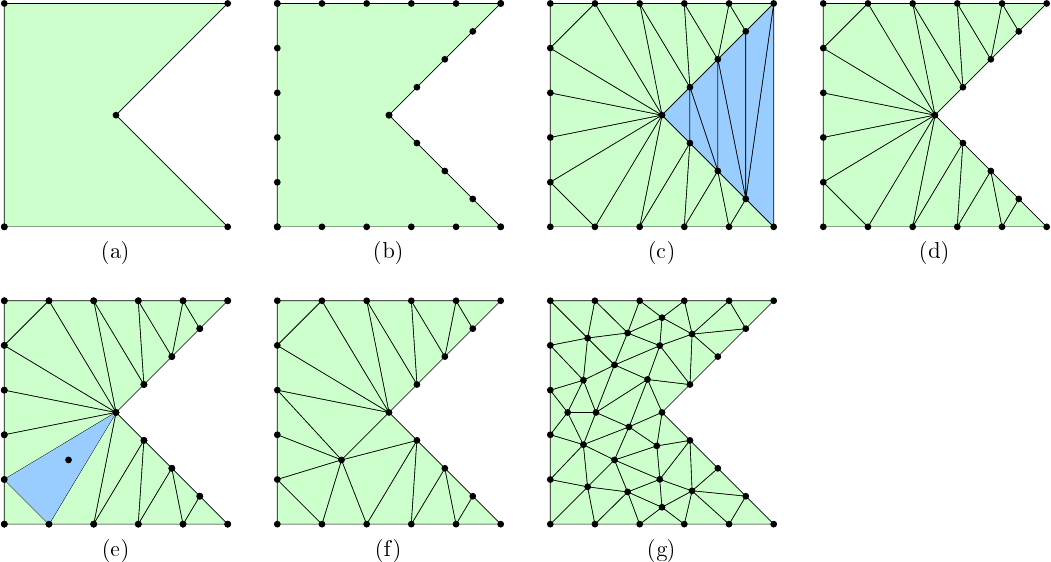

In [8]:
function pmesh(pv, hmax)
    
    #making p
    p = []
    for i in 1:(length(pv)-1)
        x_diff = pv[i+1][1]-pv[i][1]
        y_diff = pv[i+1][2]-pv[i][2]
        tot_distance = sqrt((x_diff)^2 + (y_diff)^2)
        divisions = 1
        while tot_distance/divisions > hmax 
            divisions += 1
        end
        multiplier = 1/divisions
        push!(p, [pv[i][1], pv[i][2]])
        for j in 1:(divisions-1)
            push!(p, [pv[i][1] + multiplier*j*x_diff, pv[i][2] + multiplier*j*y_diff])
        end
    end
    push!(p, [p[1][1], p[1][2]])
    
    #setting an area boolean
    no_larger_areas = false
    
    while !no_larger_areas
        
        #triangulating domain
        t = delaunay(p)
    
        #computing triangle centroids
        results = falses(length(t))
        for i in 1:length(t)
            triangle = [p[t[i][1]], p[t[i][2]], p[t[i][3]]]
            results[i] = inpolygon(tri_centroid(triangle), pv)
        end
    
        #removing outside triangle centroids
        t = t[findall(results)]
    
        #finding largest area
        largest_area = 0
        largest_triangle = 0
        for i in 1:length(t)
            triangle = [p[t[i][1]], p[t[i][2]], p[t[i][3]]]
            area = tri_area(triangle)
            if area > largest_area
                largest_triangle = triangle
                largest_area = area
            end
        end
    
        #checking if A is bigger and adding circumcenter
        if largest_area > 0.5*(hmax^2)
            push!(p, tri_circumcenter(largest_triangle))
        else
            no_larger_areas = true
        end
    end
    
    #triangulating domain for the last time
    t = delaunay(p)
    
    #computing triangle centroids
    results = falses(length(t))
    for i in 1:length(t)
        triangle = [p[t[i][1]], p[t[i][2]], p[t[i][3]]]
        results[i] = inpolygon(tri_centroid(triangle), pv)
    end
    
    #removing outside triangle centroids
    t = t[findall(results)]
    
    return p, t
    
end  

pmesh (generic function with 1 method)

### Test cases

Run the cases below to test your mesh generator.

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = delaunay(::Array{Any,1}) at In[1]:15
└ @ Main ./In[1]:15
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = delaunay(::Array{Any,1}) at In[1]:16
└ @ Main ./In[1]:16


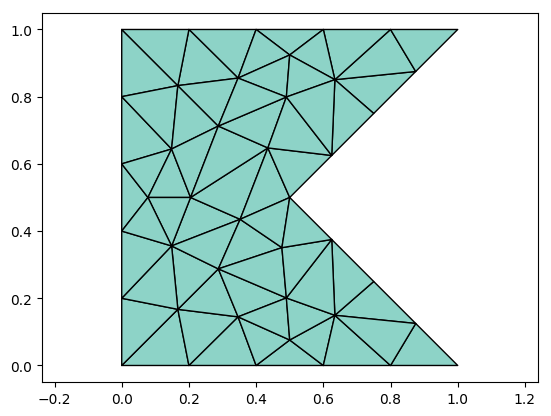

In [9]:
# The polygon in the examples
pv = [[0,0], [1,0], [0.5,.5], [1,1], [0,1], [0,0]]
p,t = pmesh(pv, 0.2)
tplot(p,t)

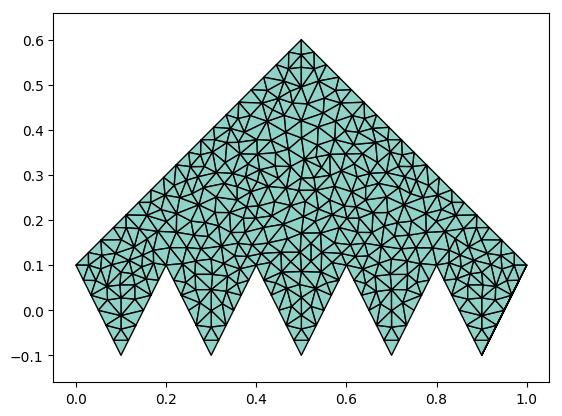

In [10]:
# A more complex shape
pv = [[i/10,0.1*(-1)^i] for i = 0:10]
append!(pv, [[.5,.6], [0,.1]])
p,t = pmesh(pv, 0.04)
tplot(p,t)